In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

##load the new calculated dataset 

In [3]:
df = pd.read_csv("Official_AivsHUman.csv", encoding="UTF-8")

In [4]:
df['Syntactic_Depth'] = df.groupby('Model')['Syntactic_Depth'].transform(lambda x: x.fillna(x.mean()))

In [5]:
metadata = df.iloc[:, :5]
text_features = df.iloc[:, 5:]

In [6]:
columns_to_drop = text_features.columns[[10, 74, 75]]
text_features= text_features.drop(columns=columns_to_drop)
#print(columns_to_drop)

In [7]:
# Get the count of documents for each type in the "label" column
label_counts = metadata['Label'].value_counts()

# Get the count of documents for each type in the "model" column
model_counts = metadata['Model'].value_counts()

# Display the results
print("Label Counts:")
print(label_counts)
print("\nModel Counts:")
print(model_counts)

Label Counts:
3    11999
4    11998
0    11997
1    11995
5    11702
2    11336
Name: Label, dtype: int64

Model Counts:
davinci    11999
bloomz     11998
human      11997
chatGPT    11995
dolly      11702
cohere     11336
Name: Model, dtype: int64


In [8]:

# Combine metadata and text_features back into one DataFrame for easier manipulation
df_combined = pd.concat([metadata, text_features], axis=1)

# Initialize lists to hold the train and test sets
test_set = pd.DataFrame()
train_set = pd.DataFrame()

# Extract 1000 documents per model for the test set
models = df_combined['Model'].unique()
for model in models:
    model_data = df_combined[df_combined['Model'] == model]
    model_test, model_train = train_test_split(model_data, test_size=len(model_data)-5000, random_state=42)
    
    # Append to the respective lists
    test_set = pd.concat([test_set, model_test])
    train_set = pd.concat([train_set, model_train])

    
    # Shuffle the train and test sets
train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)


# Verify the split
print("Test Set Composition:")
print(test_set['Model'].value_counts())

print("\nTraining Set Composition:")
print(train_set['Model'].value_counts())

# Extract the features and labels from the training set
X_train = train_set.iloc[:, 5:]  # text_features start from the 6th column
y_train = train_set['Model']

# Extract the features and labels from the test set
X_test = test_set.iloc[:, 5:]  # text_features start from the 6th column
y_test = test_set['Model']



# Ensure the data types are numeric
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Test Set Composition:
chatGPT    5000
bloomz     5000
dolly      5000
human      5000
cohere     5000
davinci    5000
Name: Model, dtype: int64

Training Set Composition:
davinci    6999
bloomz     6998
human      6997
chatGPT    6995
dolly      6702
cohere     6336
Name: Model, dtype: int64
Classification Report:
              precision    recall  f1-score   support

      bloomz       0.97      0.97      0.97      5000
     chatGPT       0.79      0.79      0.79      5000
      cohere       0.87      0.86      0.87      5000
     davinci       0.76      0.73      0.75      5000
       dolly       0.90      0.94      0.92      5000
       human       0.92      0.93      0.93      5000

    accuracy                           0.87     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.87      0.87      0.87     30000

Accuracy Score:
0.8714666666666666


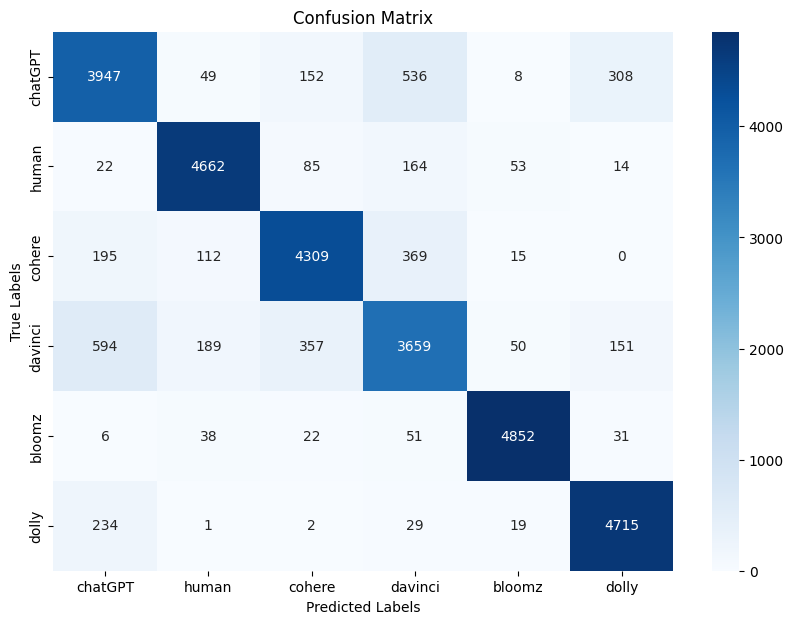


Accuracy by Model:
         Accuracy
chatGPT    0.7894
human      0.9324
cohere     0.8618
davinci    0.7318
bloomz     0.9704
dolly      0.9430


In [9]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=models)
conf_matrix_df = pd.DataFrame(conf_matrix, index=models, columns=models)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy by model
accuracy_by_model = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
accuracy_by_model_df = pd.DataFrame(accuracy_by_model, index=models, columns=['Accuracy'])

print("\nAccuracy by Model:")
print(accuracy_by_model_df)


Top 10 features for class 'bloomz':
n_uspace           4.416579
n_sconj            2.816182
t_uword            2.661823
n_udet             2.576304
simp_ttr_no_lem    2.517911
simp_ttr           2.517911
n_uadj             2.456019
a_intj_pw          2.126697
t_n_ent_date       2.109341
simp_punct_var     2.044283
Name: bloomz, dtype: float64


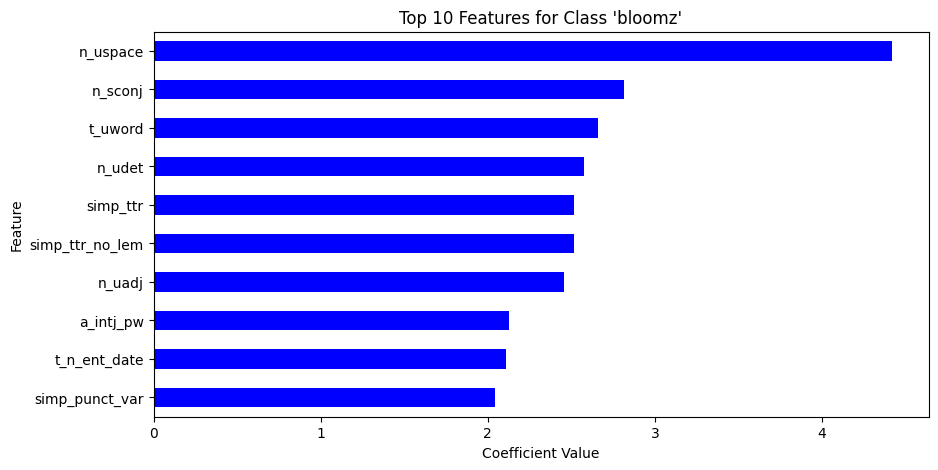


Top 10 features for class 'chatGPT':
n_uspace            3.651617
n_space             3.541754
cole                3.406100
simp_ttr_no_lem     3.219597
simp_ttr            3.219597
bilog_ttr_no_lem    2.723839
bilog_ttr           2.723839
n_verb              2.588850
n_uadj              2.473547
t_n_ent_cardinal    2.213749
Name: chatGPT, dtype: float64


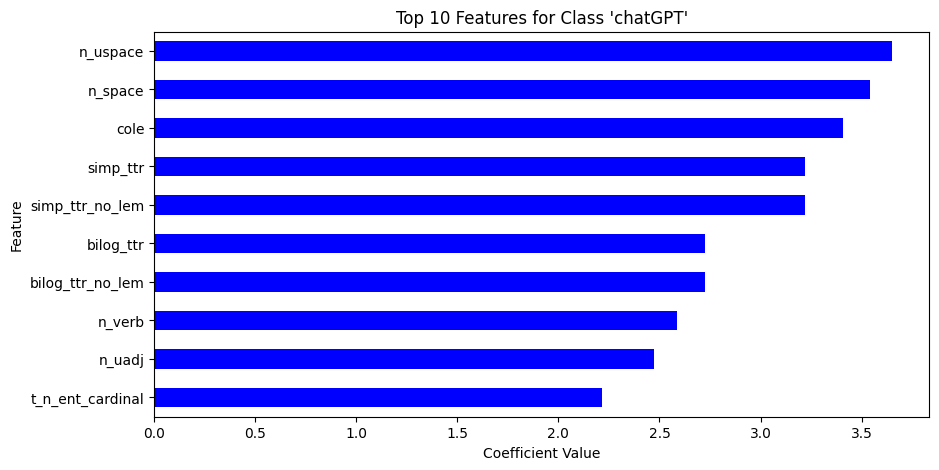


Top 10 features for class 'cohere':
a_subtlex_us_zipf_ps    1.957184
n_space                 1.771909
t_char                  1.683587
cole                    1.547596
n_udet                  1.543142
a_subtlex_us_zipf_pw    1.532969
a_char_ps               1.440079
a_verb_ps               1.351321
a_syll_ps               1.347776
simp_punct_var          1.270594
Name: cohere, dtype: float64


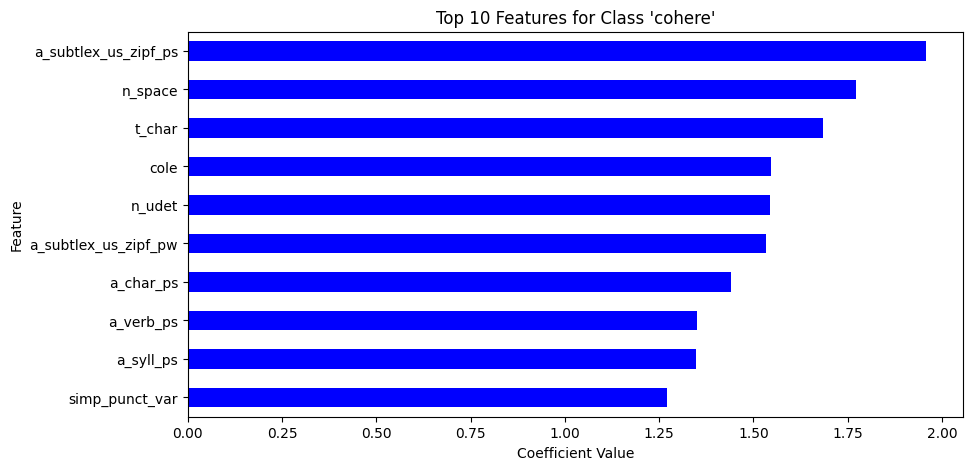


Top 10 features for class 'davinci':
t_subtlex_us_zipf    3.054184
t_bry                2.463549
a_intj_pw            2.390483
simp_space_var       1.973155
n_uadj               1.679091
simp_ttr_no_lem      1.671899
simp_ttr             1.671899
n_unoun              1.592720
t_char               1.465386
corr_noun_var        1.419940
Name: davinci, dtype: float64


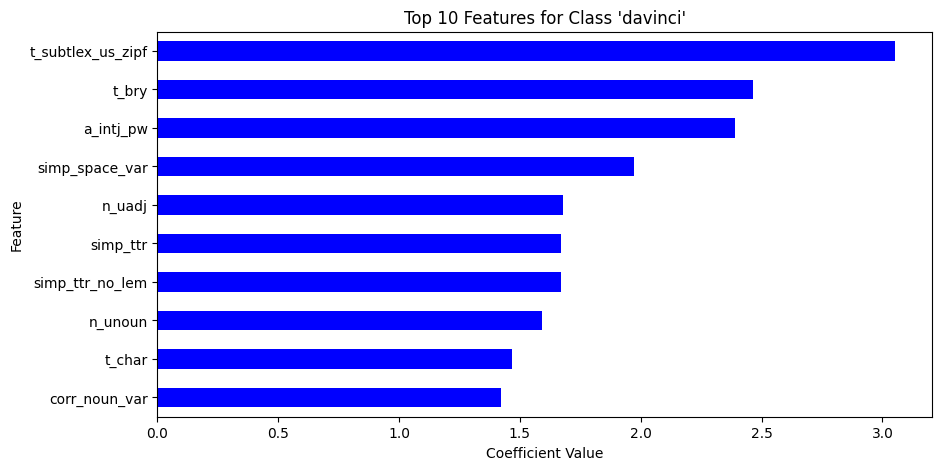


Top 10 features for class 'dolly':
n_space             3.877088
corr_space_var      3.665022
root_space_var      3.664674
n_uspace            3.250226
a_space_pw          3.047849
cole                2.796082
a_char_pw           2.510897
n_uverb             2.504455
bilog_ttr           2.049197
bilog_ttr_no_lem    2.049197
Name: dolly, dtype: float64


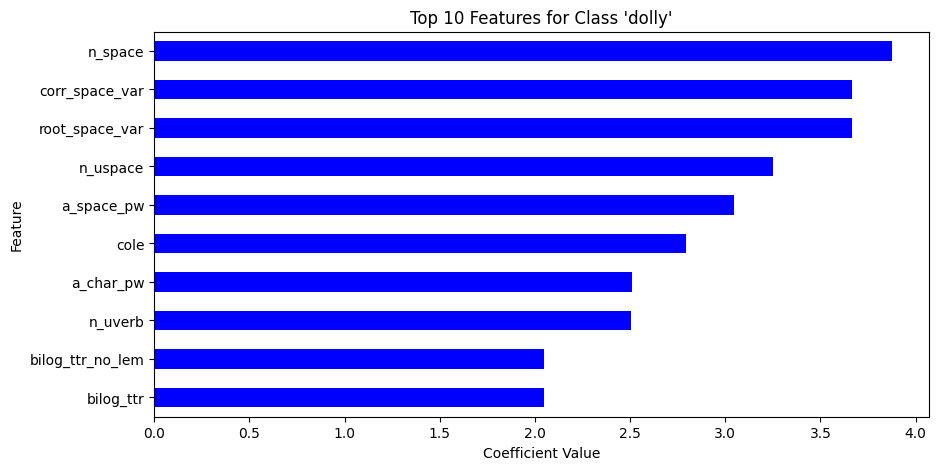


Top 10 features for class 'human':
t_uword         3.269646
n_uadv          2.803255
t_sent          2.525086
n_adp           1.797930
a_propn_pw      1.789984
a_space_ps      1.747802
a_space_pw      1.679234
n_noun          1.674499
simp_adp_var    1.670228
t_bry           1.619074
Name: human, dtype: float64


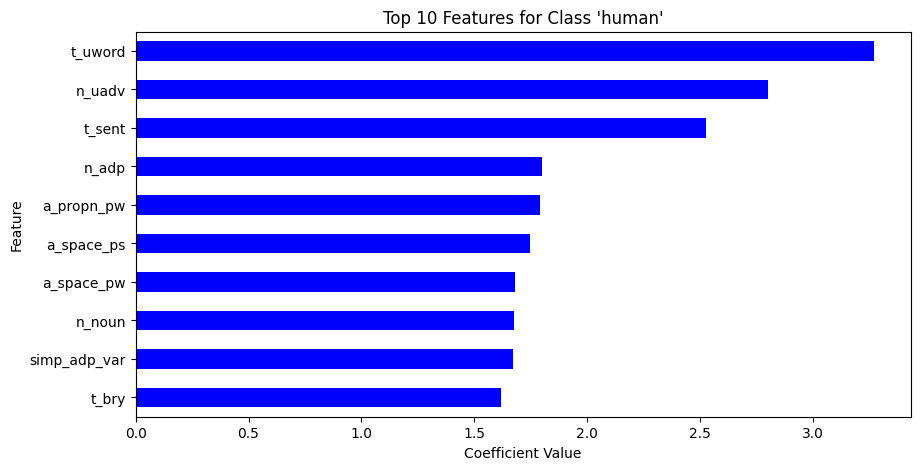

In [10]:
feature_names = X_train.columns

# Get the coefficients from the logistic regression model
coefficients = model.coef_

# Create a DataFrame to map features to their coefficients for each class
coefficients_df = pd.DataFrame(coefficients.T, index=feature_names, columns=model.classes_)

# Display the top N features per class
top_n = 10
for class_label in model.classes_:
    print(f"\nTop {top_n} features for class '{class_label}':")
    top_features = coefficients_df[class_label].abs().sort_values(ascending=False).head(top_n)
    print(top_features)

    # Plot the top features
    plt.figure(figsize=(10, 5))
    top_features.sort_values().plot(kind='barh', color='b')
    plt.title(f"Top {top_n} Features for Class '{class_label}'")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.show()


Top 10 features overall:
n_uspace            2.301293
n_space             2.015670
cole                1.850761
n_uadj              1.598015
simp_ttr_no_lem     1.487441
simp_ttr            1.487441
bilog_ttr_no_lem    1.475997
bilog_ttr           1.475997
simp_punct_var      1.473594
n_uverb             1.457574
Name: Mean_Coefficient, dtype: float64


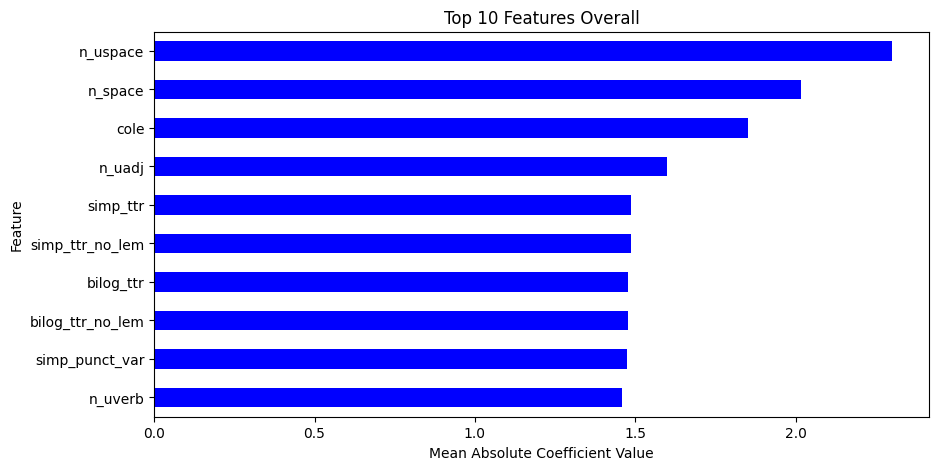

In [11]:
# Get the absolute values of the coefficients
abs_coefficients = np.abs(coefficients)

# Calculate the mean of the absolute values of the coefficients across all classes
mean_abs_coefficients = np.mean(abs_coefficients, axis=0)

# Create a DataFrame to map features to their mean absolute coefficients
mean_coefficients_df = pd.DataFrame(mean_abs_coefficients, index=feature_names, columns=["Mean_Coefficient"])

# Display the top N features
top_n = 10
top_features = mean_coefficients_df["Mean_Coefficient"].sort_values(ascending=False).head(top_n)
print(f"\nTop {top_n} features overall:")
print(top_features)

# Plot the top features
plt.figure(figsize=(10, 5))
top_features.sort_values().plot(kind='barh', color='b')
plt.title(f"Top {top_n} Features Overall")
plt.xlabel("Mean Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()